# Applying a cut to a sample and calculating the efficiency

In this example, we learn how to apply a cut in `pandas` and how to calculate the efficiency of the cut. We see how to calculate the uncertainty on the cut using the binomial error.

Some imports of what we need:

In [10]:
from root_pandas import read_root
import matplotlib.pyplot as plt
from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets
import pandas as pd
from bd2dst3pi.stats import binomial_err
import numpy as np
import scipy.stats as stats

#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Let's load the data for each year and magnet into separate DataFrames, storing them in a useful dictionary called `df`. This is just an example of how to do this, as it can be useful to work with dictionaries. We also make a total DataFrame `dt_tot` containing all years and magnets:

In [11]:
df = {}
df_tot = pd.DataFrame()
tree_name = "DecayTree"
for y in years:
    for m in magnets:
        df[f"{y}_{m}"] = read_root(f"{loc.DATA}/data_90000000_{y}_{m}.root",tree_name)
        df_tot = df_tot.append(df[f"{y}_{m}"])

We can access a specific year and magnet:

In [12]:
print(df["2015_up"].head(2))

   B0_ENDVERTEX_X  B0_ENDVERTEX_Y  B0_ENDVERTEX_Z  B0_ENDVERTEX_XERR  \
0         -1.7246         -0.6828         60.6567             0.0172   
1          2.4748          1.2210         43.5751             0.0166   

   B0_ENDVERTEX_YERR  B0_ENDVERTEX_ZERR  B0_ENDVERTEX_CHI2  B0_ENDVERTEX_NDOF  \
0             0.0086             0.1807           0.772943                  3   
1             0.0108             0.1405          15.108430                  3   

                                   B0_ENDVERTEX_COV_  B0_OWNPV_X  ...  \
0  [[0.00029584, 9.775047e-05, -0.0029697323], [9...      0.7643  ...   
1  [[0.00027556, 0.00013472892, 0.0022361316], [0...      0.7717  ...   

   DstD_BDTD  combinatorial_BDTG  combinatorial_BDT  combinatorial_BDTD  \
0   0.237036            0.812131           0.201764            0.155237   
1  -0.214430            0.559392           0.159562            0.198848   

   detachment_BDTG  detachment_BDT  detachment_BDTD isolation_BDTG  \
0        -0.786932     

In this example, we have loaded all of the variables in the `TTree`, and the printout above shows a summary of some of them for the first 2 events in the tree. 

Let's calculate the flight of the $\tau$ candidate along the $z$-axis. In our data sample, which has aready had selections applied to keep $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ decays, we won't have any genuine $\tau \to \pi^+ \pi^+ \pi^- \nu$ candidates! The three pions produced in the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ decay come directly from the $B^0$ decay vertex. Thus, the only flight we should see along the $z$-axis is due to measurement uncertainties on the vertices. 

In [13]:
df_tot["tau_flight_z"] = df_tot["tau_ENDVERTEX_Z"] - df_tot["B0_ENDVERTEX_Z"]

Let's make a quick plot of the $\tau$ candidate flight:

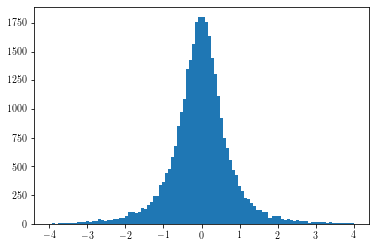

In [14]:
plt.hist(df_tot["tau_flight_z"], bins=100, range=(-4,4))
plt.show()

Indeed we find that the flight is on average zero, but with some spread. The spread is due to measurement uncertainties on the $B$ and $\tau$ vertex.

We can also calculate the flight in units of standard deviations (flight significance), by using the measured uncertainties on the $B$ and $\tau$ vertices:

In [15]:
df_tot["tau_flight_zerr"] = np.sqrt(df_tot["tau_ENDVERTEX_ZERR"]**2 + df_tot["B0_ENDVERTEX_ZERR"]**2)
df_tot["tau_flight_zsig"] = df_tot["tau_flight_z"] / df_tot["tau_flight_zerr"]

We can compare the flight significance with a standard normal distribution, which has a mean of zero and a width of 1:

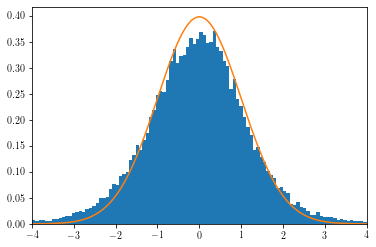

In [16]:
low = -4
high = 4
n_bins = 100
plt.hist(df_tot["tau_flight_zsig"], bins=n_bins, range=(low,high), density=True)
norm_mu = 0.
norm_sigma = 1.
x = np.linspace(norm_mu - high*norm_sigma, norm_mu + high*norm_sigma, 1000)
plt.plot(x, stats.norm.pdf(x, norm_mu, norm_sigma))
plt.xlim(low,high)
plt.show()

We see that the flight significance is indeed pretty normally distributed. The fact that the distribution has a mean of zero tells us that, on average, our three pions have zero flight from the $B$ vertex. This is consistent with the decays genuinely being $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$.

Let's count the fraction of decays which have a flight significance of more than $\pm2$ standard deviations. We expect this to be around 5\% for a perfectly normally distributed sample:

In [17]:
df_cut = df_tot.query("abs(tau_flight_zsig) >= 2")
n_pass = float(len(df_cut))
n_tot = len(df_tot)
print(f"Number with high flight significance: {n_pass}")
print(f"Total number: {n_tot}")

Number with high flight significance: 3349.0
Total number: 31573


We can calculate the efficiency of this cut by taking the ratio. The absolute uncertainty on this efficiency is given by the binomial formula $\sigma_\epsilon = \frac{1}{N}\sqrt{k(1 - \frac{k}{N})}$. Code for calculating this error given a number passing the cut ($k$) and the total number ($N$) is provided in `bd2dst3pi/stats.py`.

In [18]:
eff = n_pass / n_tot
eff_err = binomial_err(n_tot, n_pass)
print(f"Efficiency of abs(tau_flight_zsig) >= 2 cut: {eff:.3f} +/- {eff_err:.3f}")

Efficiency of abs(tau_flight_zsig) >= 2 cut: 0.106 +/- 0.002


The efficiency is actually higher than 5%, because our distribution of flight significance is not quite normal (you can see it has tails at larger values in the plot above).

**Follow-up tasks**

- How does the flight significance look in MC? Is the distribution similar to the data?
- Compare the efficiency of the flight cut in data and MC. Which one is higher, and why could that be?
- Can you calculate the 3-dimensional flight distance? You can use Pythagoras theorem to help, so $L = \sqrt{x^2 + y^2 + z^2}$. How about the 3-dimensional flight significance?